In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [24]:
# plot settings
plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['font.size'] = 12
# plt.rcParams["figure.figsize"] = (5,3)  # good default size for column-width figure
# plt.rcParams["figure.figsize"] = (8,5)  # good default size for column-width figure

# force matplotlib to plot inline
%matplotlib inline
# %matplotlib qt

In [3]:
def trigger(x, y, threshold_y, refresh_x):
    """Returns the indices of the rising edges in the signal which are above a given threshold and at least "refresh" indices apart in the array"""
    high_i = np.where(y > threshold_y)[0]  # indices of values that are above the threshold
    high_x = np.array(x[high_i]) # times where signal is above the threshold

    rising_i = np.where(np.diff(high_x) > refresh_x)[0] + 1 # indices of "high_x" where previous high value is more than refresh rate away
    trig_i = high_i[rising_i]
    trig_x = x[trig_i]  # subset of high_x that is only the rising times
    trig_y = y[trig_i]  # subset of signal that is only at the rising times

    return trig_i, trig_x, trig_y

In [15]:
def average_pulses(signal_df, channel_key, threshold_y, refresh_x, window, lead):
    trig_i, trig_x, trig_y = trigger(signal_df['time'], -signal_df['sync_trig'], threshold_y, refresh_x)
    n_pulses = len(trig_i)

    start = round(window / lead)  # number of points before trigger
    end = window - start  # number of points after trigger

    pulses_time = np.zeros((n_pulses, window))
    pulses_trig = np.zeros((n_pulses, window))
    pulses_sig = np.zeros((n_pulses, window))

    for pulse_n, pulse_index in enumerate(trig_i):
        pulses_time[pulse_n] = signal_df['time'][pulse_index - start:pulse_index + end] - signal_df['time'][pulse_index] # time relative to pulse trigger
        pulses_trig[pulse_n] = signal_df['sync_trig'][pulse_index - start:pulse_index + end]
        pulses_sig[pulse_n] = signal_df[channel_key][pulse_index - start:pulse_index + end]

    mean_time = np.mean(pulses_time, axis=0)
    mean_signal = np.mean(pulses_sig, axis=0)
    mean_trigger = np.mean(pulses_trig, axis=0)

    return pulses_time, mean_time, pulses_trig, mean_trigger, pulses_sig, mean_signal

# 04 - 10fff, 30 MU @ 2400 MU/min

In [19]:
# import the csv
# each scope div is 25 ns, pulses are just under 3 ms apart
filename1 = '20250312_04_10MVfff.csv'
sig1 = pd.read_csv(filename1, header=0, names=['time', 'sig_ac', 'lin_out', 'sync_trig'], skiprows=[1,2], dtype=np.float64)

# remove unwanted channels and convert all units to V
sig1['sig_ac'] = sig1['sig_ac'] / 1000  # mV to V
sig1['lin_out'] = sig1['lin_out'] / 1000  # mV to V
sig1['time'] = sig1['time'] * 1000  # ms to us

Text(0.5, 0.98, '20250312_04_10MVfff.csv')

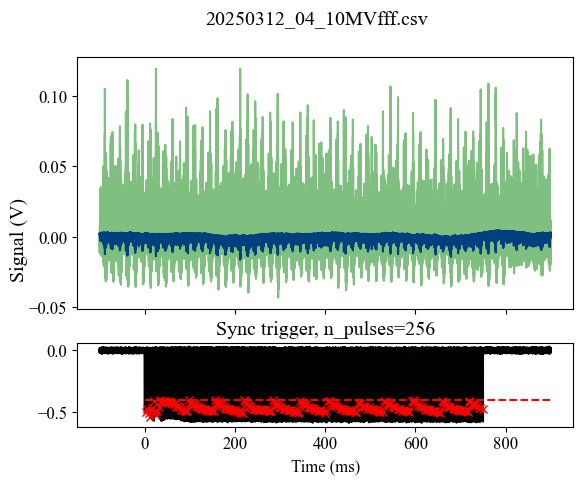

In [20]:
threshold = 0.4
refresh = 2 # ms
trig_i, trig_x, trig_y = trigger(sig1['time'], -sig1['sync_trig'], threshold, refresh)
n_pulses = len(trig_x)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(sig1['time'] / 1000, sig1['sig_ac'], 'b', label='AC Signal')
ax[0].plot(sig1['time'] / 1000, sig1['lin_out'], 'g', alpha=0.5, label='LinOut')
ax[0].legend
# ax[0].set_title('Signals')

ax[1].plot(sig1['time'] / 1000, sig1['sync_trig'], 'k')
ax[1].plot(trig_x / 1000, -trig_y, "xr")
ax[1].plot([0, sig1['time'].iloc[-1] / 1000],[-threshold, -threshold], '--r')
ax[1].set_title(f'Sync trigger, n_pulses={n_pulses}')
ax[1].set_xlabel('Time (ms)')

fig.supylabel('Signal (V)')
fig.suptitle(filename1)

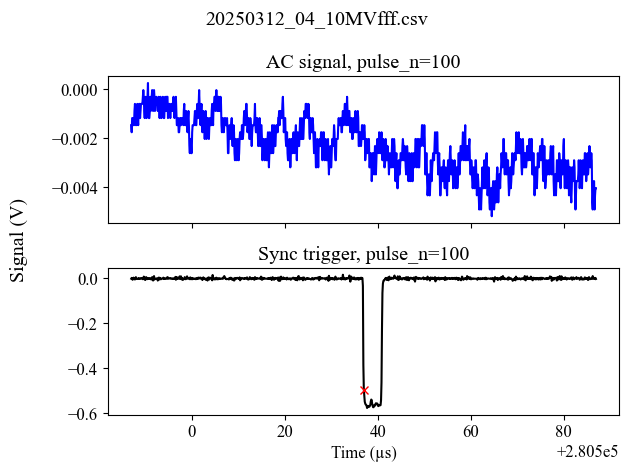

In [21]:
# show single pulse
pulse_n = 100 # successfully index pulses from 1-119 (even though there are 120 pulses, drop the first one)

window = 1000
start = round(window/2)  # number of points before trigger
end = window - start  # number of points after trigger

x = sig1['time'][trig_i[pulse_n]-start:trig_i[pulse_n] + end]
sync_trig = sig1['sync_trig'][trig_i[pulse_n]-start:trig_i[pulse_n] + end]
signal = sig1['sig_ac'][trig_i[pulse_n]-start:trig_i[pulse_n] + end]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(x, signal, 'b')
ax[0].set_title(f'AC signal, pulse_n={pulse_n}')

ax[1].plot(x, sync_trig, 'k')
ax[1].plot(sig1['time'][trig_i[pulse_n]], sig1['sync_trig'][trig_i[pulse_n]], "xr")
ax[1].set_title(f'Sync trigger, pulse_n={pulse_n}')
ax[1].set_xlabel('Time (µs)')

fig.supylabel('Signal (V)')
fig.suptitle(filename1)
# plt.setp(ax, xlim=(77.5, 78), ylim=(-0.025, 0))
fig.tight_layout()

Text(0.5, 0.98, '20250312_04_10MVfff.csv')

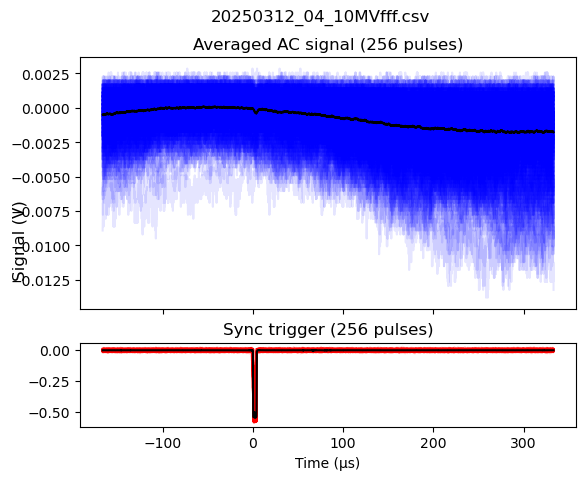

In [25]:
pulses_time, mean_time, pulses_trig, mean_trigger, pulses_sig, mean_signal = average_pulses(sig1, 'sig_ac', threshold_y=0.1, refresh_x=2000, window=5000, lead=3)
n_pulses=pulses_time.shape[0]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(pulses_time.T, (pulses_sig.T), 'b', alpha=0.1)
ax[0].plot(mean_time, mean_signal, 'k')
ax[0].set_title(f'Averaged AC signal ({n_pulses} pulses)')

ax[1].plot(pulses_time.T, pulses_trig.T, 'r', alpha=0.1)
ax[1].plot(mean_time, mean_trigger, 'k')
# ax[1].plot([pulses_time.T[0], pulses_time.T[-1]],[-threshold, -threshold], '--r')
ax[1].set_title(f'Sync trigger ({n_pulses} pulses)')
ax[1].set_xlabel('Time (µs)')

# plt.setp(ax, xlim=(-0.0001, 0.0002))

fig.supylabel('Signal (V)')
fig.suptitle(filename1)

Text(0.5, 0.98, '20250312_04_10MVfff.csv')

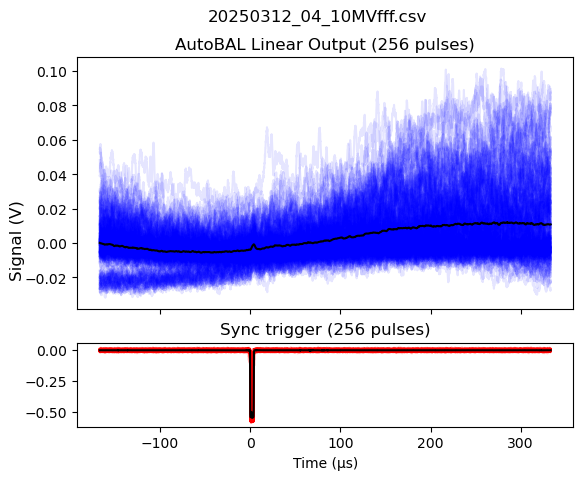

In [27]:
pulses_time, mean_time, pulses_trig, mean_trigger, pulses_sig, mean_signal = average_pulses(sig1, 'lin_out', threshold_y=0.1, refresh_x=2000, window=5000, lead=3)
n_pulses=pulses_time.shape[0]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(pulses_time.T, (pulses_sig.T), 'b', alpha=0.1)
ax[0].plot(mean_time, mean_signal, 'k')
ax[0].set_title(f'AutoBAL Linear Output ({n_pulses} pulses)')

ax[1].plot(pulses_time.T, pulses_trig.T, 'r', alpha=0.1)
ax[1].plot(mean_time, mean_trigger, 'k')
# ax[1].plot([pulses_time.T[0], pulses_time.T[-1]],[-threshold, -threshold], '--r')
ax[1].set_title(f'Sync trigger ({n_pulses} pulses)')
ax[1].set_xlabel('Time (µs)')

# plt.setp(ax, xlim=(-0.0001, 0.0002))

fig.supylabel('Signal (V)')
fig.suptitle(filename1)

# 18 - 10fff, 15MU @ 2400 MU/min

In [9]:
# import the csv
# each scope div is 25 ns, pulses are just under 3 ms apart
filename2 = '20250121 c08 Ethanol Argon pH12 10MV-1s 5MU.csv'
sig2 = pd.read_csv(filename2, header=0, names=['time', 'sig_ac', 'sync_trig'], skiprows=[1,2], dtype=np.float64)
sig2['sig_ac'] = sig2['sig_ac'] / 1000
sig2['time'] = sig2['time'] * 1000  # ms to us

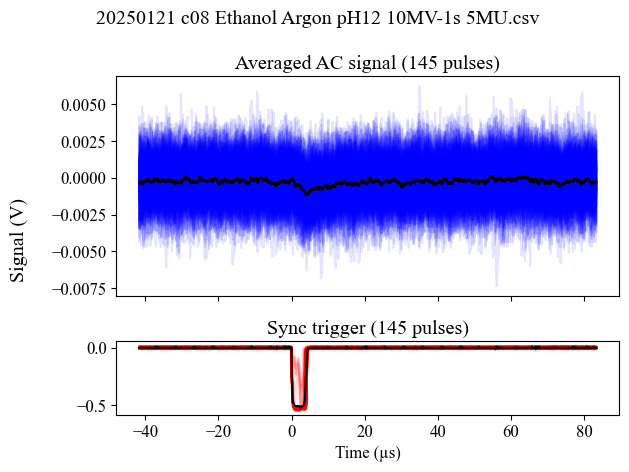

In [10]:
pulses_time, mean_time, pulses_trig, mean_trigger, pulses_sig, mean_signal = average_pulses(sig2, threshold_y=0.03, refresh_x=2000, window=5000, lead=3)
n_pulses=pulses_time.shape[0]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(pulses_time.T, (pulses_sig.T), 'b', alpha=0.1)
ax[0].plot(mean_time, mean_signal, 'k')
ax[0].set_title(f'Averaged AC signal ({n_pulses} pulses)')

ax[1].plot(pulses_time.T, pulses_trig.T, 'r', alpha=0.1)
ax[1].plot(mean_time, mean_trigger, 'k')
ax[1].set_title(f'Sync trigger ({n_pulses} pulses)')
ax[1].set_xlabel('Time (µs)')

fig.supylabel('Signal (V)')
fig.suptitle(filename2)
fig.tight_layout()